# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Data Preparation

In [2]:
diabetes_data = pd.read_csv('.\diabetes.csv')
diabetes_data.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# Analysing Data

In [3]:
diabetes_data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

This dataset will be used to predict the likelihood that a woman has diabetes. 

Dataset contains 8 features:

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)

There seems to be missing data for Glucose, BloodPressure, SkinThickness, and Insulin as their minimum values are out of range.

In [4]:
diabetes_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Positive cases are almost half of the size of negative cases. There is a class imbalance.

268/500 = 0.536

In [5]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There are no null values or non-numerical datatypes. 

In [6]:
diabetes_data.shape

(768, 9)

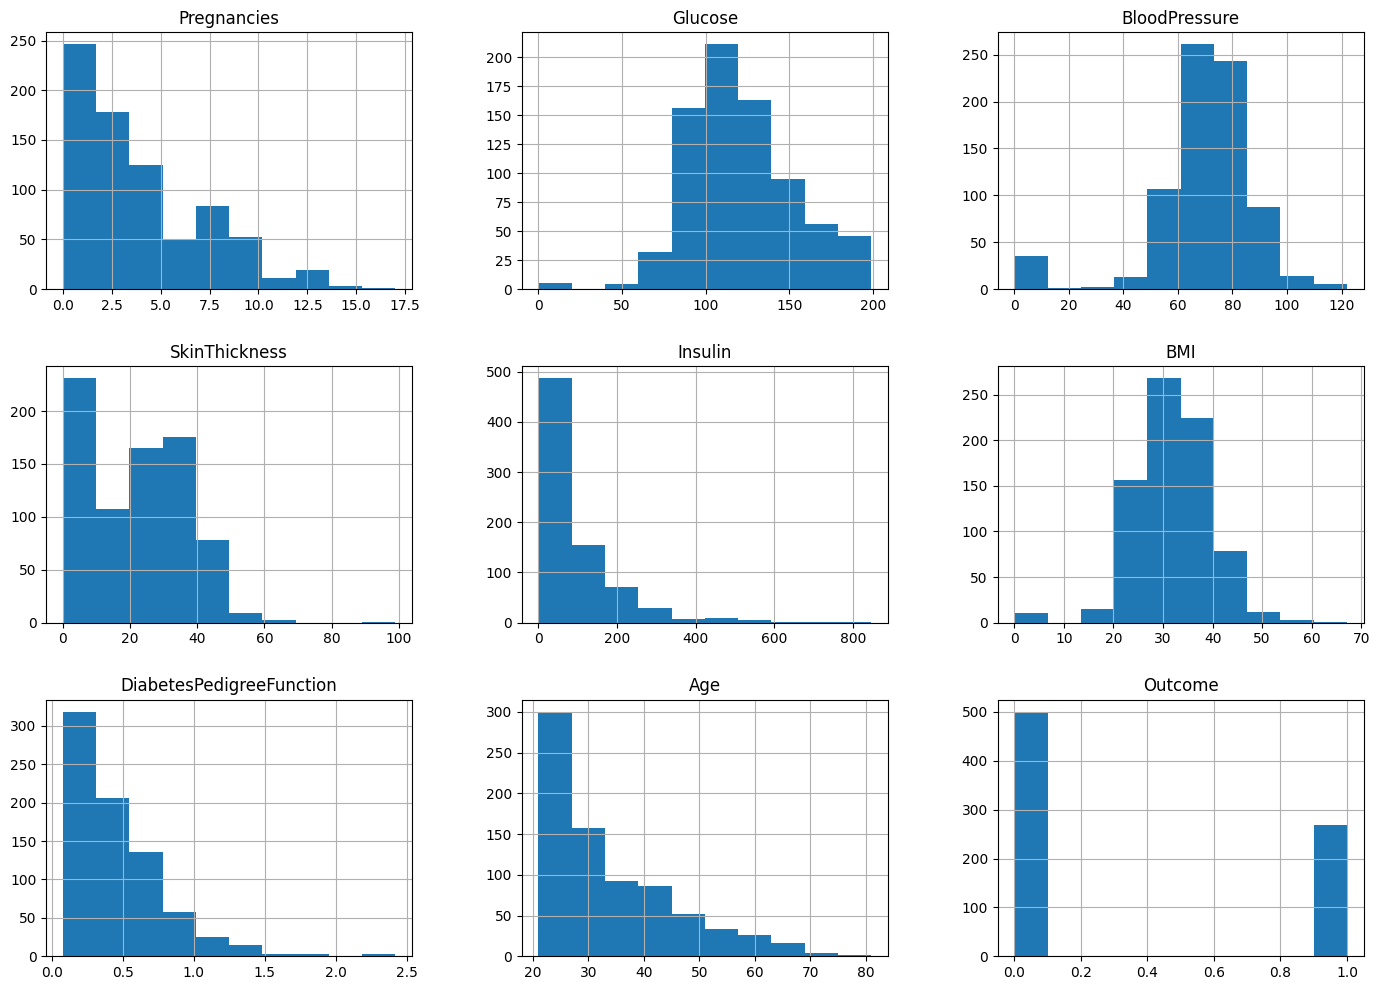

In [7]:
diabetes_data.hist(figsize=(17,12))
plt.show()

There are lots of 0 values in Glucose, BloodPressure, SkinThickness, Insulin and BMI. Moreover, SkinThickness and Insulin have more 0 cases than any other class as shown in the above histogram. 

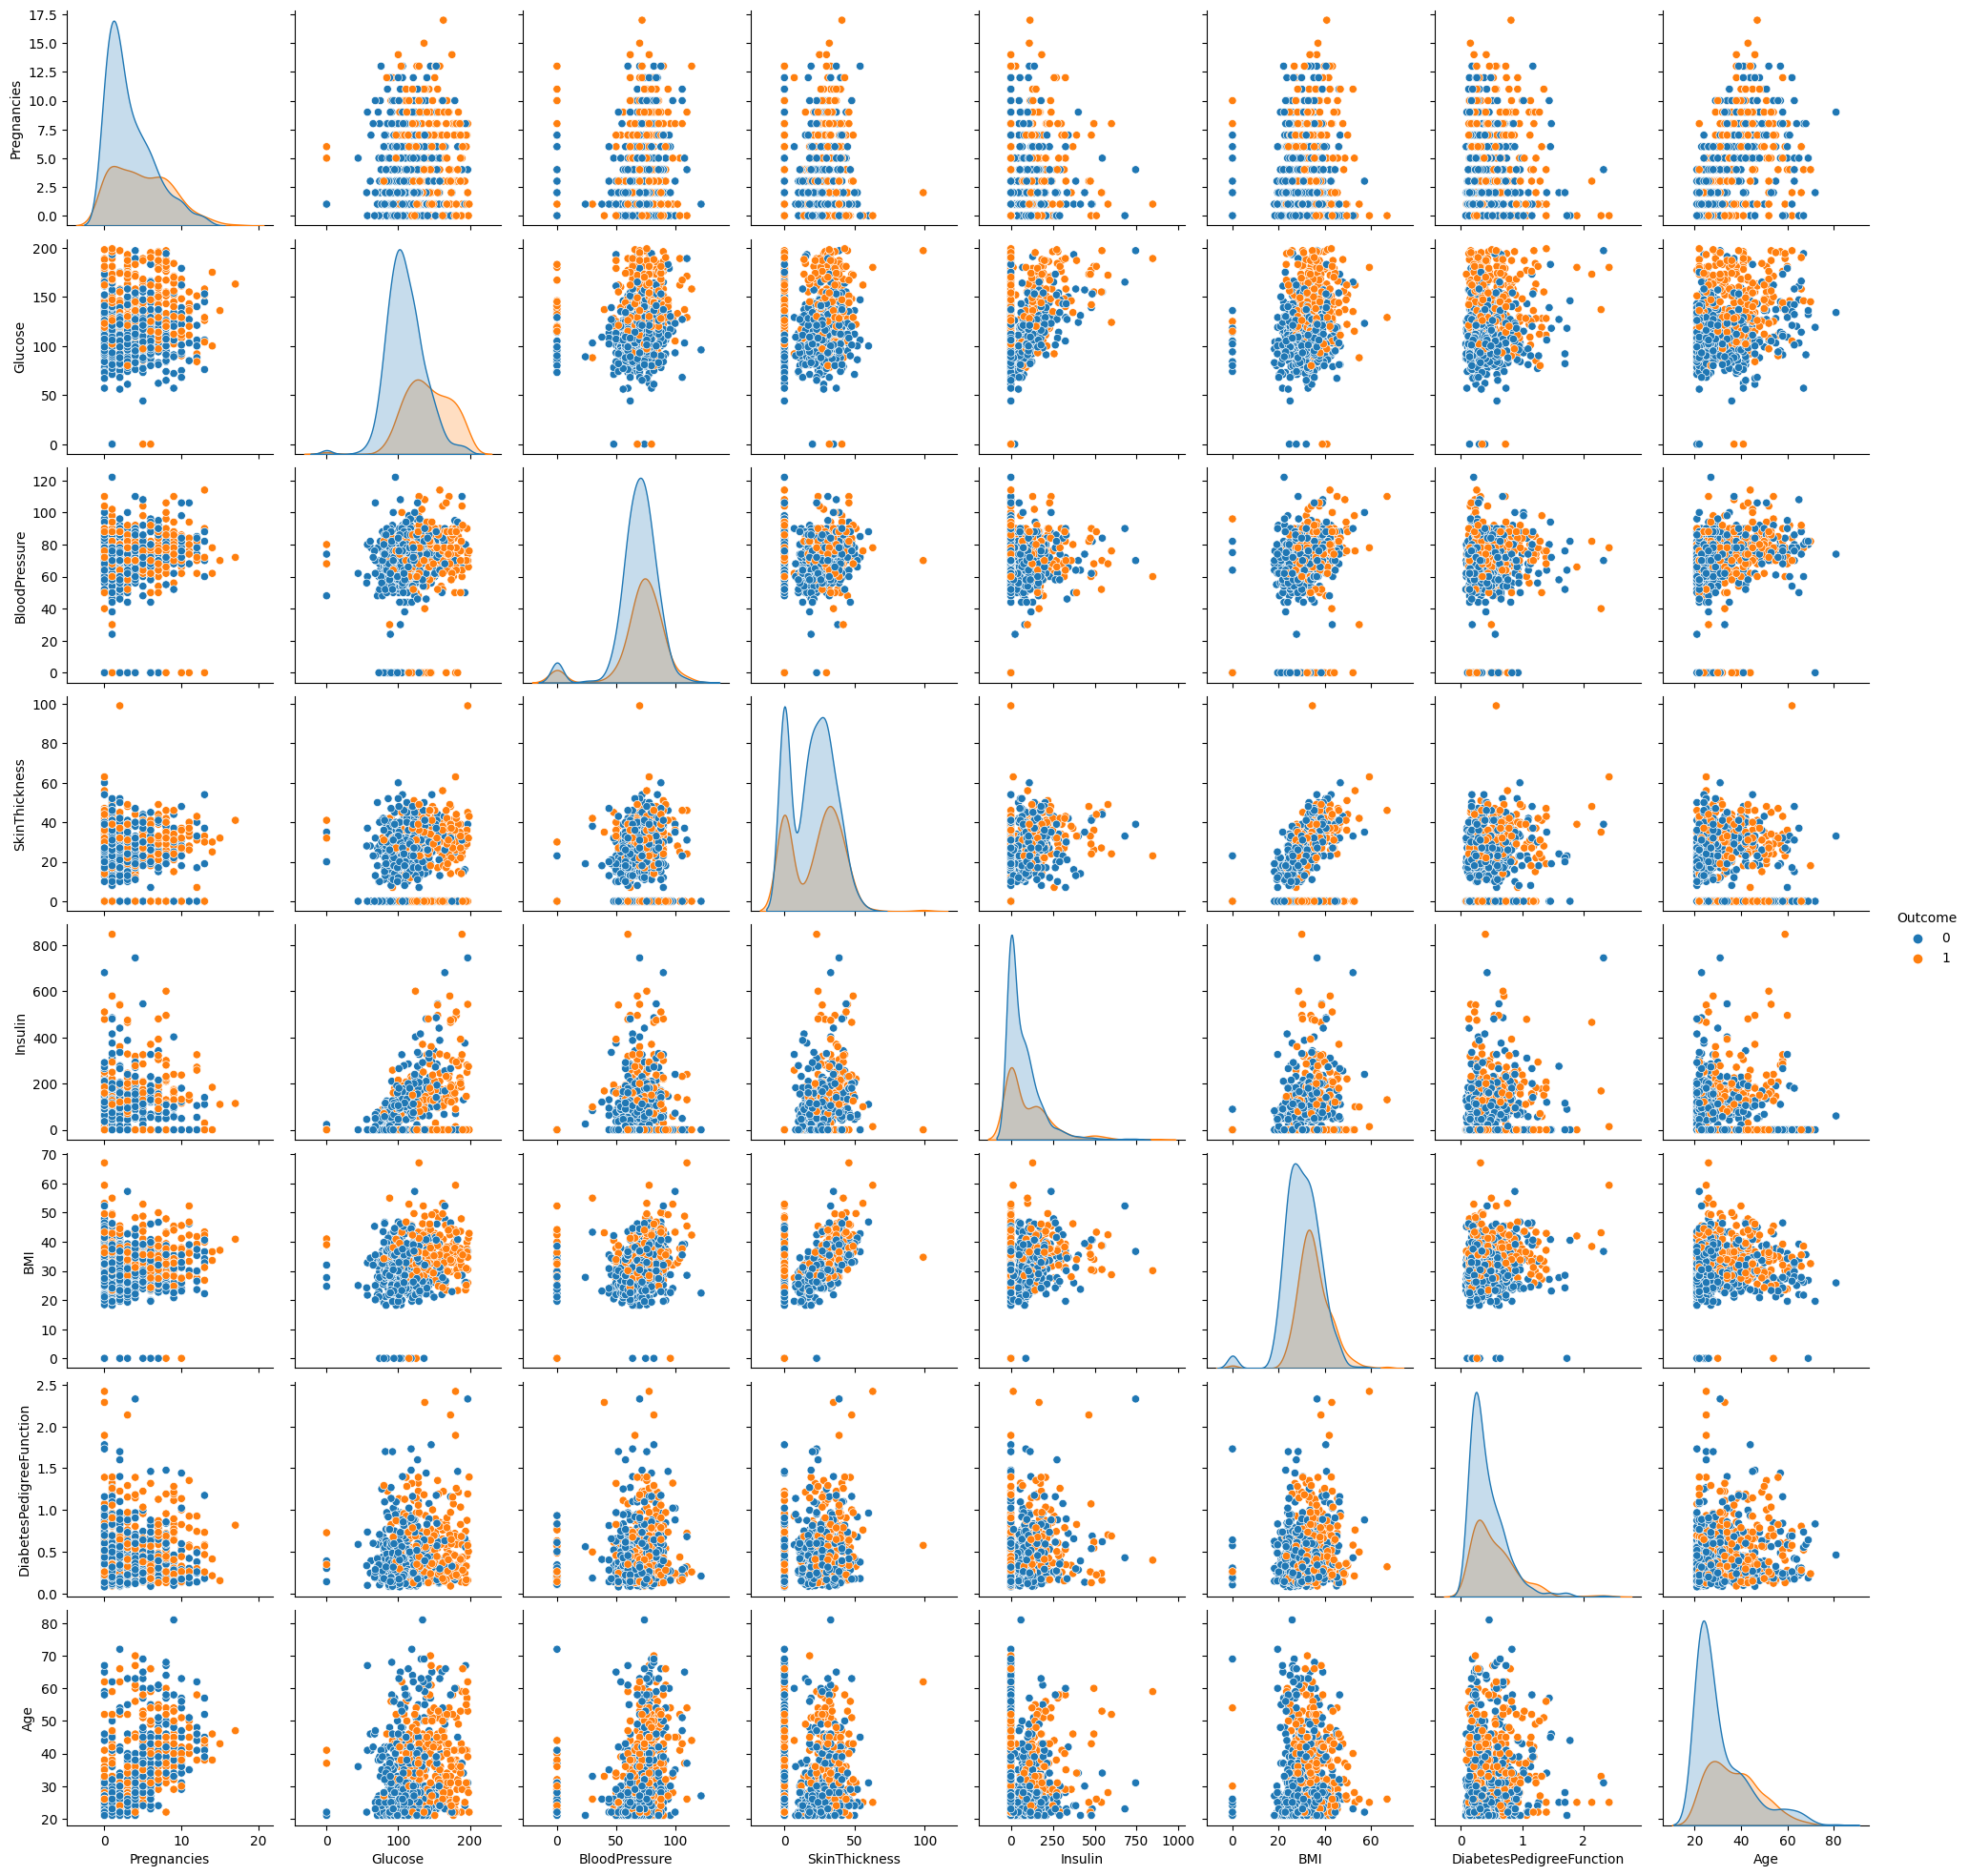

In [8]:
sns.pairplot(diabetes_data, hue="Outcome", height=2.5)

### Observations:
- Lots of outliers and missing/zero datapoints
- Noisy dataset

In [9]:
print("Duplicate values in Diabetes_Data:", diabetes_data.duplicated().sum())
zero_counts = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_data['Glucose'].count()

for feature in zero_counts:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('Zeros in {0}: {1}, Percentage: {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))


Duplicate values in Diabetes_Data: 0
Zeros in Glucose: 5, Percentage: 0.65%
Zeros in BloodPressure: 35, Percentage: 4.56%
Zeros in SkinThickness: 227, Percentage: 29.56%
Zeros in Insulin: 374, Percentage: 48.70%
Zeros in BMI: 11, Percentage: 1.43%


There are no duplicate values in the dataset.

### Based on research:
- A person with 0 glucose levels may feel very confused, pass out, or have a seizure. Without prompt treatment, severe hypoglycemia may lead to a coma or even death.

- Moreover, 0 Insulin levels will again lead a person to a severe hyperglycemia. That is high blood sugar level that leads to a state called diabetic ketoacidosis (DKA), which untreated leads to death.

- If blood pressure drops too low, the body’s vital organs do not get enough oxygen and nutrients. When this happens, low blood pressure can lead to shock.


### What to do with the dataset:

- There are five patients that have no blood pressure. It is not feasible to have no blood pressure and live. This will be replaced by calculating mean.

- Since roughly half of the patients have no insulin. It is acceptable to infer that people with 0 insulin levels are diabetic. However, there are some patients with no insulin that are not classified as diabetic. These could be misclassifications. To avoid further misclassifications, mean could be used to replace missing/misclassified data in order to improve accuracy.

- As for SkinThickness (Triceps skin fold thickness). It is not possible to have 0 skin. This will also be replaced by mean.

- As shown in the above graphs, the number of zero values in the SkinThickness and Insulin characteristics appears to be large.
Let's modify the relevant values to the feature's mean value.  

# Preprocessing Data

### Replacing zero values with mean

In [10]:
diabetes_mean = diabetes_data[zero_counts].mean()
diabetes_data[zero_counts]=diabetes_data[zero_counts].replace(0, diabetes_mean)

In [11]:
diabetes_data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.681605      72.254807      26.606479  118.660163   
std       3.369578   30.436016      12.115932       9.631241   93.080358   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      20.536458   79.799479   
50%       3.000000  117.000000      72.000000      23.000000   79.799479   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450805                  0.471876   33.240885    0.348958  
std      6.875374                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [12]:
diabetes_data.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0           72.0      35.000000   79.799479  33.6   
1            1     85.0           66.0      29.000000   79.799479  26.6   
2            8    183.0           64.0      20.536458   79.799479  23.3   
3            1     89.0           66.0      23.000000   94.000000  28.1   
4            0    137.0           40.0      35.000000  168.000000  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

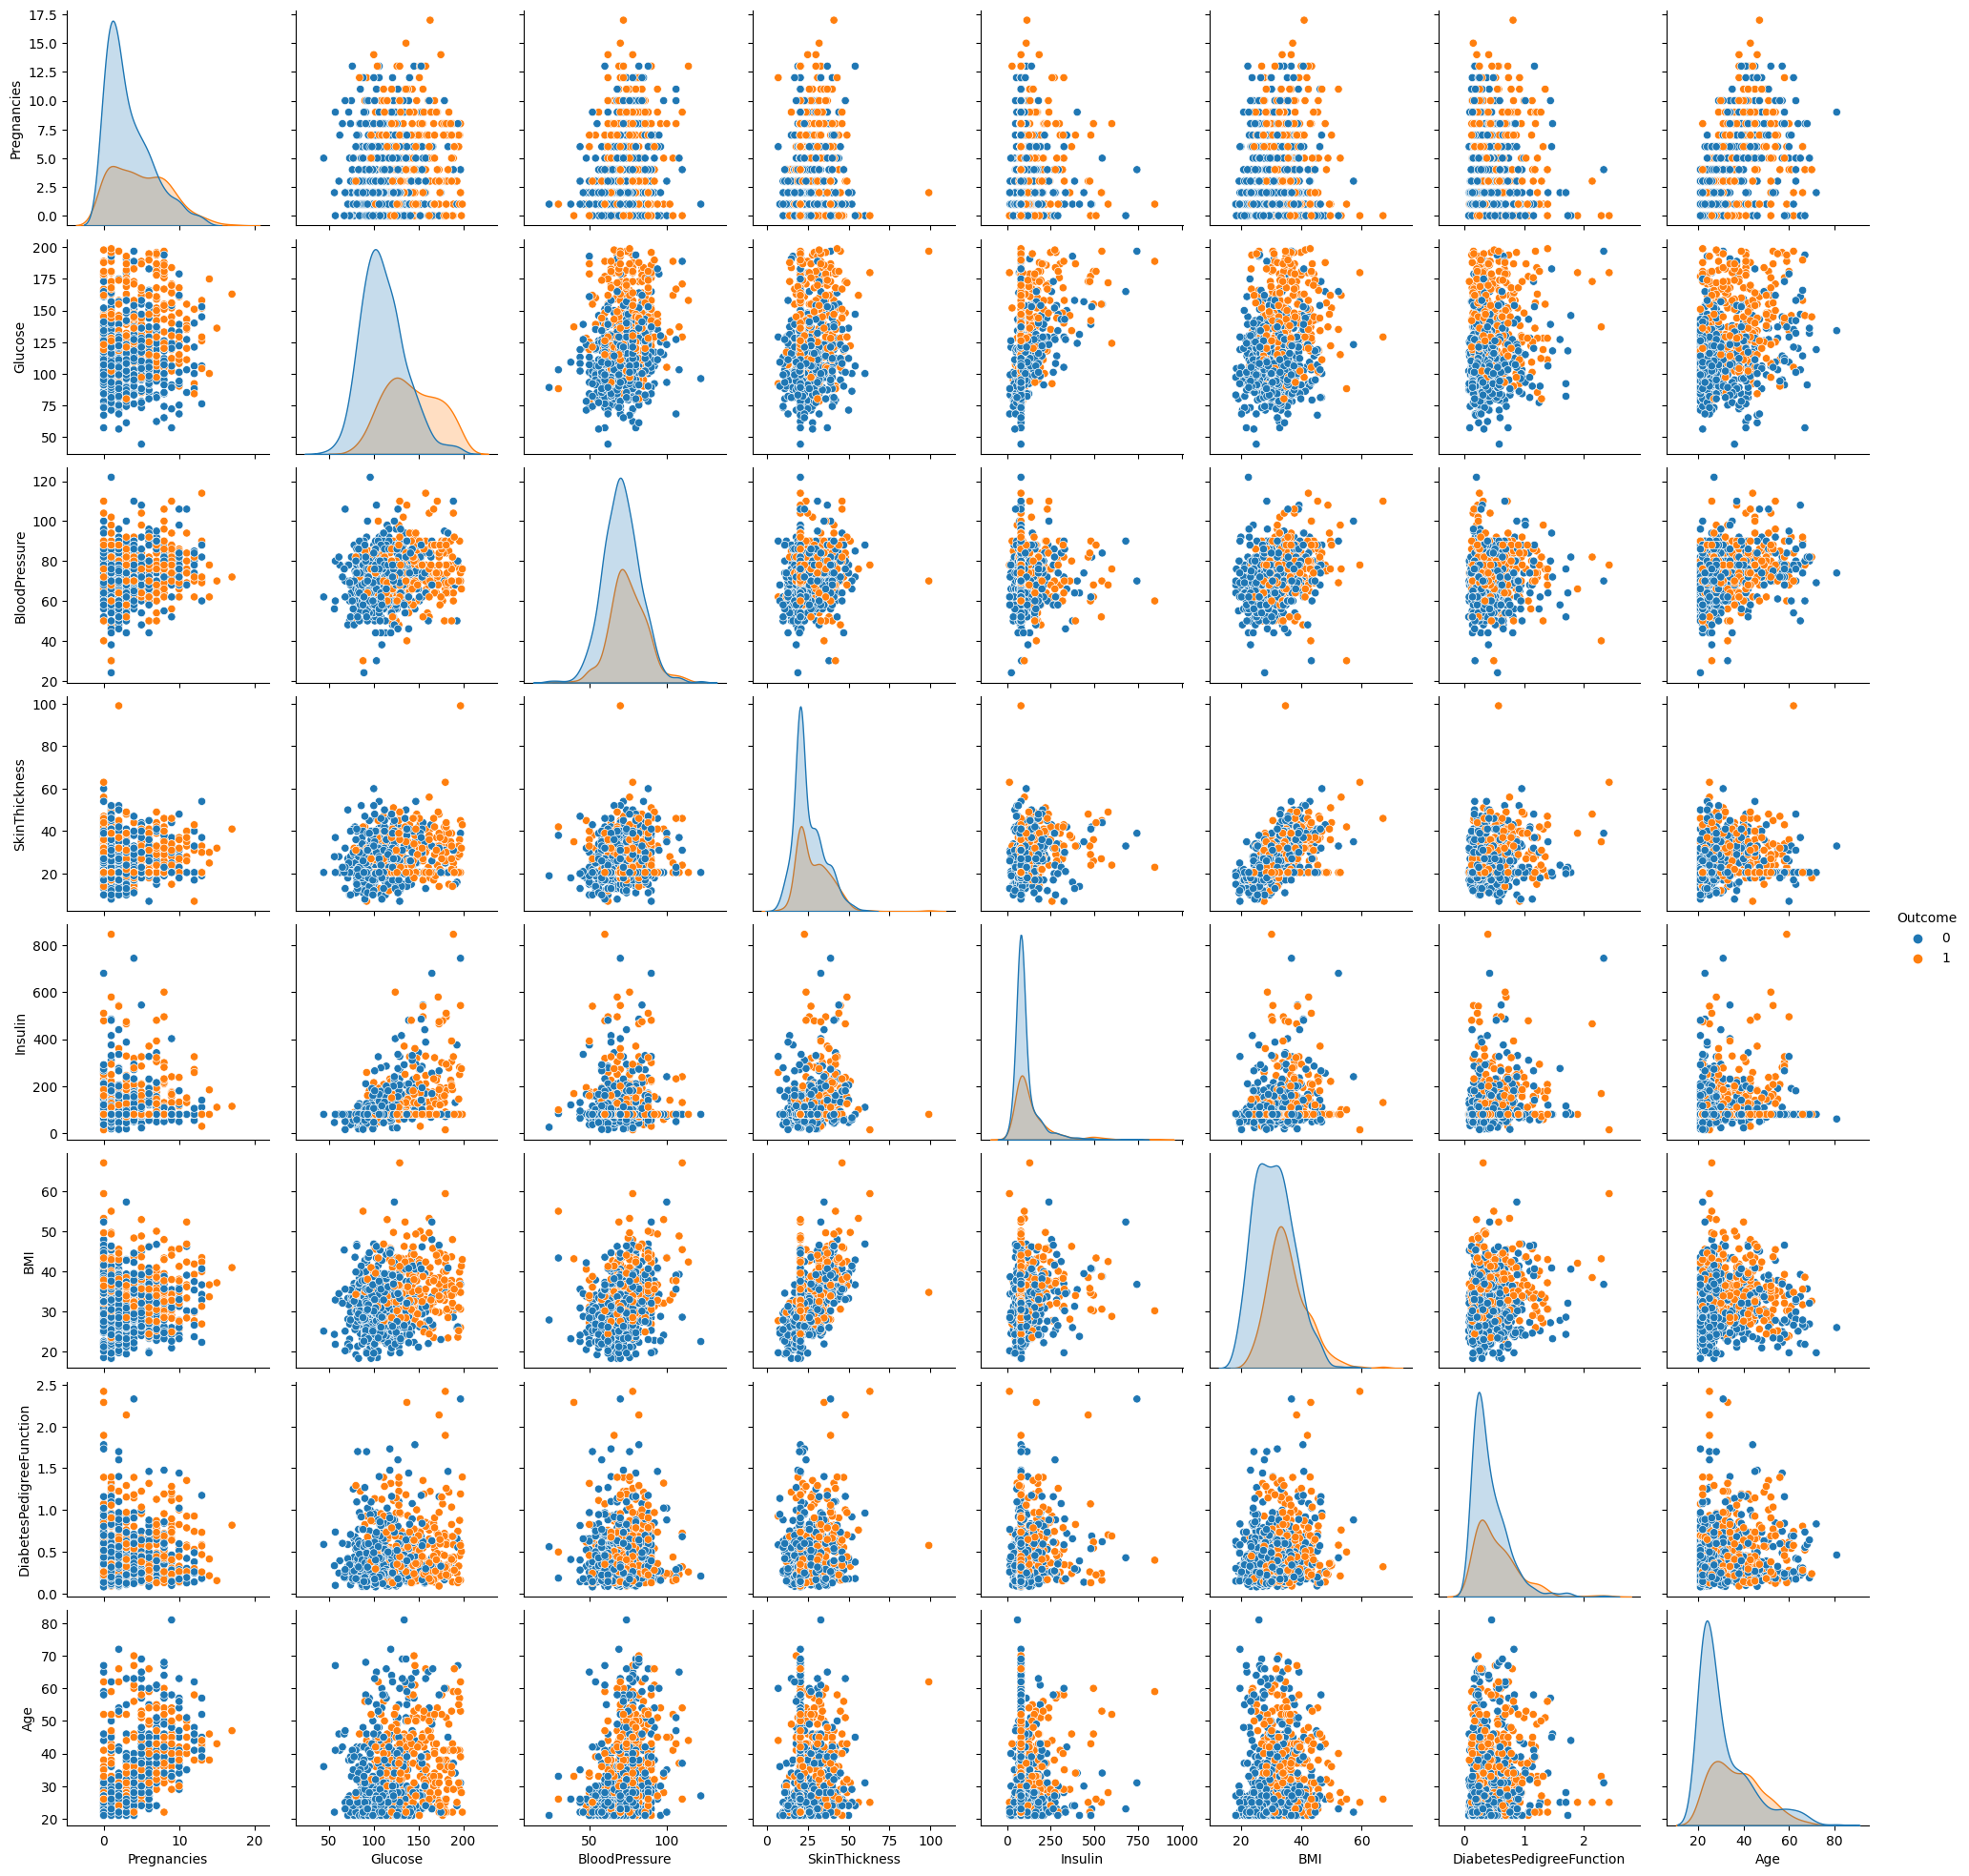

In [13]:
sns.pairplot(diabetes_data, hue="Outcome", height=2.5)

Removed missing data as shown in the above graphs.

Great! we've replaced the missing data (zero) from Glucose, BloodPressure, SkinThickness, Insulin and BMI with the mean.

## Correlation Graph

<Axes: title={'center': 'Correlation Graph'}>

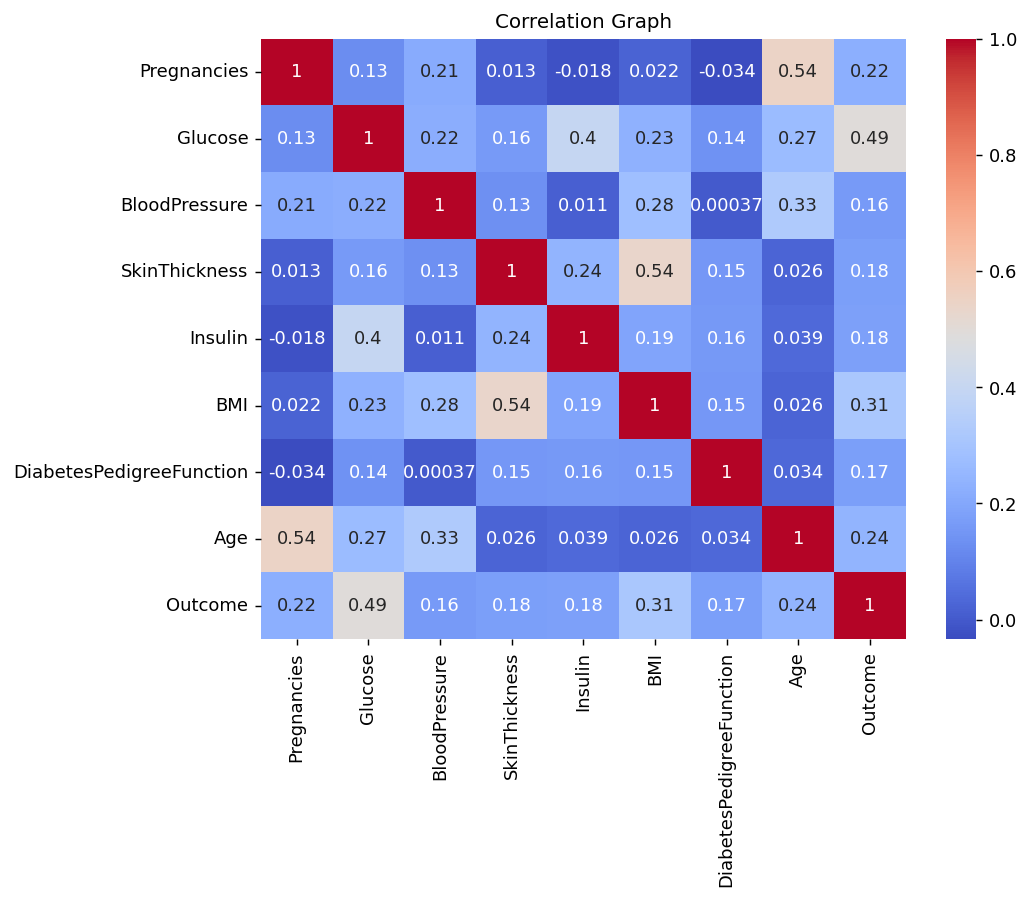

In [14]:
plt.figure (figsize = [8,6],  dpi = 130 )
plt.title ("Correlation Graph" , fontsize = 11 )
sns.heatmap (diabetes_data.corr(), annot = True , cmap="coolwarm" )

### Observations:
- The relationship between outcome and glucose is strong.
The most essential feature in model training appears to be glucose.

- Features like pregnancies, BMI, and age are not as important as glucose but they also remain influencial.

- There is a strong correlation between age & pregancies and skinThickness & BMI.

# Training and testing the model

## Creating the training dataset & Feature selection

In [15]:
feature_df = diabetes_data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

#Independent variables
X=np.asarray(feature_df)

#Dependent variable
y=np.asarray(diabetes_data['Outcome'])

X[0:1]


array([[  6.        , 148.        ,  72.        ,  35.        ,
         79.79947917,  33.6       ,   0.627     ,  50.        ]])

Except for glucose, the outcome exhibits a low correlation with each feature. And deleting all other characteristics except glucose would be impractical. So it is best to keep all features as such variables still have small influence on the outcome and would only marginally enhance the model's performance.

We will be using all the features from the dataset for out model

In [16]:
y[0:10]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=int64)

## Spliting training and testing data.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
X_train.shape

(576, 8)

Train/test size will be 75/25. The dataset is quite noisy and complex so, a higher percentage of data can be used for training set. This can improve its performance. With more training data, the model can learn more complex relationships and patterns in the data, leading to better generalization on unseen data and capture the underlying patterns in the data and reduce the effects of noise.

In [18]:
X_test.shape

(192, 8)

In [19]:
y_train.shape

(576,)

In [20]:
y_test.shape

(192,)

# SVM - Polynomial

## Testing hyperparameters

I used several parameters to accomplish the most effective outcomes, including: 

- SVC(kernel="poly", C=0.1, coef0=0.1, degree=1)
- SVC(kernel="poly", C=1, coef0=1, degree=1)
- SVC(kernel="poly", C=1, coef0=1, degree=2)
- SVC(kernel="poly", C=0.1, coef0=0.1, degree=2)
- SVC(kernel="poly", C=1, coef0=1, degree=2)
- SVC(kernel="poly", C=5, coef0=5, degree=2)
- SVC(kernel="poly", C=5, coef0=5, degree=3)
- SVC(kernel="poly", C=10, coef0=10, degree=3)

Obviously, showing all of their outcomes here would take a lot of time and space, so I've chosen and compared three of the parameters that perform reasonably well. 

### Hyperparameters 1

When C=1, coef0=1 and degree=2

In [21]:
SVM_low = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", C=1, coef0=1, degree=2)) 
])

SVM_low.fit(X_train, y_train)

# Accuracy
print("SVM polynomial Accuracy:", SVM_low.score(X, y)*100)

# 10-fold cross-validation
scores_low = cross_val_score(SVM_low, X, y, cv=10)
mean_accuracy = np.mean(scores_low)
print("SVM poly cross-validation mean:", mean_accuracy*100)

# Classification report
y_predict_low = SVM_low.predict(X_test)
print("\n"+classification_report(y_test, y_predict_low))

SVM polynomial Accuracy: 79.03645833333334
SVM poly cross-validation mean: 76.30724538619276

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       126
           1       0.68      0.64      0.66        66

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.74       192
weighted avg       0.77      0.77      0.77       192



### Hyperparameters 2

When C=5, coef0=5 and degree=2

In [22]:
SVM_med = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", C=5, coef0=5, degree= 2)) 
])
SVM_med.fit(X_train, y_train)

# Accuracy
print("SVM polynomial Accuracy:", SVM_med.score(X, y)*100)

# 10-fold cross-validation
scores_med = cross_val_score(SVM_med, X, y, cv=10)
mean_accuracy = np.mean(scores_med)
print("SVM poly cross-validation mean:", mean_accuracy*100)

# Classification report
y_predict_med = SVM_med.predict(X_test)
print("\n"+classification_report(y_test, y_predict_med))

SVM polynomial Accuracy: 79.03645833333334
SVM poly cross-validation mean: 76.30724538619276

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       126
           1       0.62      0.65      0.64        66

    accuracy                           0.74       192
   macro avg       0.72      0.72      0.72       192
weighted avg       0.75      0.74      0.75       192



### Hyperparameters 3

When C=10, coef0=10 and degree=3

In [23]:
SVM_high = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", C=10, coef0=10, degree= 3)) 
])
SVM_high.fit(X_train, y_train)

# Accuracy
print("SVM polynomial Accuracy:", SVM_high.score(X, y)*100)

# 10-fold cross-validation
scores_high = cross_val_score(SVM_high, X, y, cv=10)
mean_accuracy = np.mean(scores_high)
print("SVM poly cross-validation mean:", mean_accuracy*100)

# Classification report
y_predict_high = SVM_high.predict(X_test)
print("\n"+classification_report(y_test, y_predict_high))

SVM polynomial Accuracy: 84.50520833333334
SVM poly cross-validation mean: 74.62235133287766

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       126
           1       0.59      0.65      0.62        66

    accuracy                           0.72       192
   macro avg       0.70      0.71      0.70       192
weighted avg       0.73      0.72      0.73       192



Please note the chosen hyperparameters are C=1, coef0=1, degree=2 (Hyperparameter 1)

Each of these parameters has benefits and drawbacks, for example, our chosen parameters has a slightly low recall (for accurately identifying positive cases) score than 1 & 2 parameter models. However, our chosen hyperparameters in general outperform all of these models in terms of accuracy, overall precision and recall (f1-score).

### SVM Kernel and Parameter Tunning

- A polynomial kernel was selected because it allows a more flexible decision boundary compared to a linear kernel. Making it suitable for non-linear and complex datasets. It is also more computationally efficient than RBF kernels, which can be computationally expensive for large datasets.

- chosing C value of 1 is beneficial in situations where the data is noisy or when there are many irrelevant or redundant features in the dataset, a simpler model with a wider margin may be more effective at generalizing to new data Which is particularly useful in diabetes dataset.

- Setting coef0 to 1 means that higher-order terms in the polynomial kernel will be given more emphasis relative to lower-order terms. This can make the decision boundary more flexible and record more complex relationships between features and the outcome. Nevertheless, increasing the coefficient may increase the risk of overfitting the model. 

- A degree of 2 was chosen because it can capture nonlinear relationships while still maintaining some level of simplicity in the model. Thus, maintain a good balance between flexibility and simplicity, which then leads to better generalization performance on new data.

## Training Data SVM Polynomial
### Using Pipeline and Standard Scaler

In [24]:
SVM_poly = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", C=1, coef0=1, degree= 2)) 
])
SVM_poly.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, coef0=1, degree=2, kernel='poly'))])

### Why use Pipeline with Standard Scaler?

- Since SVMs are sensitive to input data size, larger scale features can dominate the optimisation process. Using a StandardScaler to scale the data can assist to minimize this effect and ensure that all characteristics contribute equally to the model. 

- It is essential that the same scale is applied to both the training and test sets when doing cross-validation or parameter tuning.
If the scaling is applied to the training and test sets independently, it might cause data leaking and overfitting.
By implementing a pipeline, the same scaling is applied to both the training and test sets.

- Overall, combining a pipeline with a StandardScaler can help boost the performance and stability of a SVM model using a polynomial kernel. 

### Accuracy and 10-fold cross-validation score for SVM Polynomial

In [25]:
print("SVM polynomial Accuracy:", SVM_poly.score(X, y)*100)

SVM polynomial Accuracy: 79.03645833333334


In [26]:
scores = cross_val_score(SVM_poly, X, y, cv=10)
mean_accuracy = np.mean(scores)
print("SVM poly cross-validation mean:", mean_accuracy*100)

SVM poly cross-validation mean: 76.30724538619276


## Evaluating SVM

#### Training Prediction

In [27]:
y_predict_train_svm_poly = SVM_poly.predict(X_train)
print(classification_report(y_train, y_predict_train_svm_poly))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       374
           1       0.77      0.60      0.67       202

    accuracy                           0.80       576
   macro avg       0.79      0.75      0.76       576
weighted avg       0.79      0.80      0.79       576



#### Testing Data

In [28]:
y_predict = SVM_poly.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       126
           1       0.68      0.64      0.66        66

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.74       192
weighted avg       0.77      0.77      0.77       192



SVM with Polynomial Kernel predicts diabetes with 77% accuracy, which is not an optimal model. For forecasting negative situations, the model is far more accurate with 82% precision. The same is true for recall at 84%. However, the model is ineffective in identifying positive cases. Just 68% of the positive occurrences in the test data were accurately predicted by the model. In regards to recall, the model projected that 34% of diabetic patients in the test data do not have diabetes, which is far from desirable. 

There is a primary explanation for the model's low performance in identifying true positives. It has to do with the class imbalance, with a nearly 2:1 ratio of negative to positive cases, rendering it bias. As a result, the model's ability to anticipate negative situations becomes more likely. 

### Confusion Matrix

<Axes: >

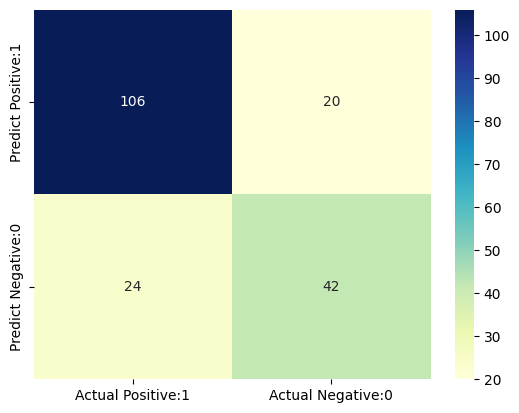

In [29]:
cm = confusion_matrix(y_test,y_predict)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Advantages of using SVM:
- It is effective in high-dimensional spaces and can handle large feature sets.
- SVM can effectively model non-linear decision boundaries using kernel tricks such as polynomial kernel.
- Is robust to overfitting and has a good generalization performance.

### Disadvantages of using SVM:
- SVM is sensitive to the choice of kernel function and the tuning of hyperparameters.
- SVM can be sensitive to imbalanced datasets or noisy data such as diabetes dataset.
- It is a computationally intensive model, especially for large datasets.

# Ensemblers

## Voting Classifier - Hard voting

We will be using a voting classifer as it can train many base models or estimators and predicts by aggregating their results. It integrates the predictions of multiple individual models to generate a final prediction. This method is frequently used to boost the accuracy and robustness of machine learning models making it ideal to use it in this dataset.

We will be using a voting classifier with hard voting which makes a final prediction based on the majority vote of individual models.

### Standard Scaler

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

We will be using 3 classifiers: Random forest, logistic regression and decision tree for the voting classifier.

### Voting classifier models

In [31]:
#support_vector = SVC(probability=True, random_state=42)
random_forest = RandomForestClassifier()
logistric_reg = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion='gini')

### Hyperparameter tuning for Voting classifier models

- Decision tree: A decision tree with a depth of 3 is relatively shallow and simple, which can make it more interpretable and less prone to overfitting.
- Logistic regression: max_iter set to 1000 to find the most optimal solution (due to noisy data) and avoid convergence errors.

In [32]:
voting_classifier = VotingClassifier(estimators=[('rfc', random_forest), ('lr', logistric_reg), ('dtc', decision_tree)], voting='hard')
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rfc', RandomForestClassifier()),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('dtc', DecisionTreeClassifier(max_depth=3))])

### Accuracy and 10-fold cross-validation score for Voting Classifier

In [33]:
for clf in (random_forest, logistric_reg, decision_tree, voting_classifier):
    clf.fit(X_train, y_train)
    y_pred_vrc = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred_vrc)*100)

RandomForestClassifier 78.125
LogisticRegression 81.25
DecisionTreeClassifier 81.77083333333334
VotingClassifier 80.72916666666666


In [34]:
scores_vc = cross_val_score(voting_classifier, X, y, cv=10)
print('Voting clf cross-validation mean:', scores_vc.mean()*100)

Voting clf cross-validation mean: 76.16883116883118


There is little to no improvement in cross validation accuracy. This may indicate that the model has reached its limit of predictive power on the given diabetes dataset or that the model may require more hyperparameter tuning.

## Evaluating Voting Classifier

### Training Prediction for Voting classifier

In [35]:
y_predict_train_voting = voting_classifier.predict(X_train)
print(classification_report(y_train, y_predict_train_voting))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       374
           1       0.80      0.64      0.71       202

    accuracy                           0.82       576
   macro avg       0.81      0.78      0.79       576
weighted avg       0.82      0.82      0.81       576



### Testing Data for Voting classifier

In [36]:
y_predict_test_voting = voting_classifier.predict(X_test)
print(classification_report(y_test, y_predict_test_voting))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       126
           1       0.71      0.74      0.73        66

    accuracy                           0.81       192
   macro avg       0.79      0.79      0.79       192
weighted avg       0.81      0.81      0.81       192



Implementing a voting classifier with three models: random forest, logistic regression, and decision tree improved the model's accuracy and performance significantly. Accuracy increased from 77% to 82%, which is a noticeable difference. Precision and recall have also increased, and the gap between correctly identifying precision and accuracy for both positive and negative cases has shrunk, with positive case precision and recall currently standing at 73% and 74%, respectively, a 5% improvement for positive precision and 10% for recall. However, The gap between postive/negative precision and accuracy still remains large due to a class imbalance in the dataset. 

<Axes: >

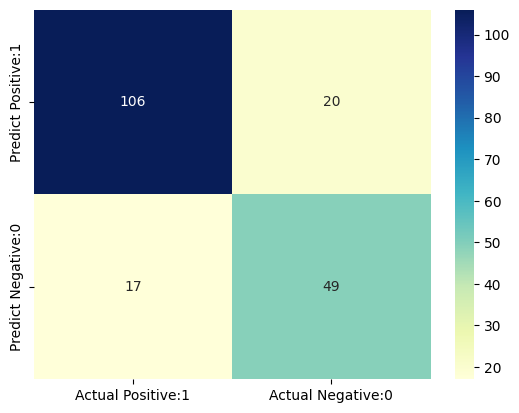

In [37]:
cm = confusion_matrix(y_test, y_predict_test_voting)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

There are three reasons why the dataset's performance increased dramatically:
- A voting classifier can help to reduce overfitting by combining the predictions of multiple models that have been trained on different subsets of the data. Thus, better generalization.
- Can be more robust to outliers or noisy data than individual models, as it combines the predictions of multiple models.
- Each model has their own strengths and weaknesses, and combining them can help to reduce the impact of any individual model's weaknesses while amplifying their strengths.

There are still drawbacks when using Voting classifier:

- A voting classifier involves the training and combining of numerous independent models, which might raise the overall complexity of the model.
- If the individual models applied in a voting classifier overfit to the training data, the voting classifier may overfit to the training data as well, resulting in poor performance on unseen data.
- If the individual models employed in a voting classifier are biassed in the same way, the voting classifier may be biassed as well as seen with the clas imbalance present in diabetes_data.

# Conclusion

Diabetes is predicted with 77% accuracy using SVM with Polynomial Kernel, which is not an ideal model. The model is significantly more accurate at forecasting negative occurrences, with an 82% precision. The same is true for recall, which stands at 84%. The model, however, is unsuccessful at finding positive cases. The model correctly predicted just over 60% of the positive events in the test data. In regards to recall, the model predicted that 34% of diabetic individuals in the test data did not have diabetes, which is clearly unacceptable. 

So instead, we used an ensemble modal called voting classifier to accurately predict diabetes using three models (random forest, logistic regression, and decision tree) which considerably enhanced the model's accuracy and performance. The accuracy went from 77% to 82%, which is a decent improvement.  Precision and recall have also improved, with positive case precision and recall now just over 72%, representing a nearly 5% improvement for precision and 10% for recall. Even so, due to a class imbalance, missing data and noisiness in the dataset, the difference between positive/negative precision and accuracy remains low for the analysing diabetes. The quality of data seems to be rather poor.

# References

Team, D. (2022) How Long Can Your Body Survive Without Insulin? Healthline.11 April 2022 [online]. Healthline Media. Available from: https://www.healthline.com/diabetesmine/ask-dmine-lifespan-sans-insulin#What-happens-when-you-run-out-of-insulin? [Accessed 22 March 2023].

‌Endocrine Society (2022) Severe Hypoglycemia Endocrine.org.18 February 2022 [online]. Endocrine Society. Available from: https://www.endocrine.org/patient-engagement/endocrine-library/severe-hypoglycemia [Accessed 22 March 2023].

‘Low Blood Pressure’ (2022) NHLBI, NIH.24 March 2022 [online]. Available from: https://www.nhlbi.nih.gov/health/low-blood-pressure [Accessed 30 March 2023].